できるだけ簡素なtransformerを定義したい  
事前学習モデルの一部を使って重みは初期化。  
事前学習から行い、８クラス分類にヘッドを変えることで実現する  
  
### 今回は事前学習タスクであるマスク推測ができて学習ができていそうだったら成功とする  
->挫折（泣）  ただ参考になるのでこのまま残す　v19に最初から８クラス分類するBERTを実装　

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, BertConfig
import seaborn as sns

import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


# データ用意

In [2]:
import numpy as np
fold = "../../train_raw_npy/"
acc_x = np.loadtxt("../../train_raw/Acc_x.txt")
label = np.load(f"{fold}sampled_label.npy")

print(acc_x.shape)
print(label.shape)


(196072, 500)
(196072,)


## データは生データを等頻度ビニングとする
生値を等頻度ビニングする    
事前学習ではすべてのデータを対象にビニングするが、今はランダムのものだけを使っている。  
少しでも学習ができて精度が改善しそうであれば今回はよしとする  
このbinsは未知データでも同じものを使う必要がある。tokenizerみたいな感じ  
予約トークン101,102,103を避けるためにシフト  
  
トークンは104~になるはず

Max index after shifting: 5104
Vocab size: 5105
Sample discrete data: [[4091 4092 4099 ... 1129 1375 1485]
 [1559 1577 1382 ... 1602 1609 1585]
 [1499 1394 1255 ... 4283 4272 4299]
 ...
 [2760 2514 3253 ... 4438 3632 1623]
 [ 728 2148 2772 ... 3927 4211 4065]
 [2219 2147 3659 ... 1336 2174 3062]]
Discrete data range: 104 to 5104


c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


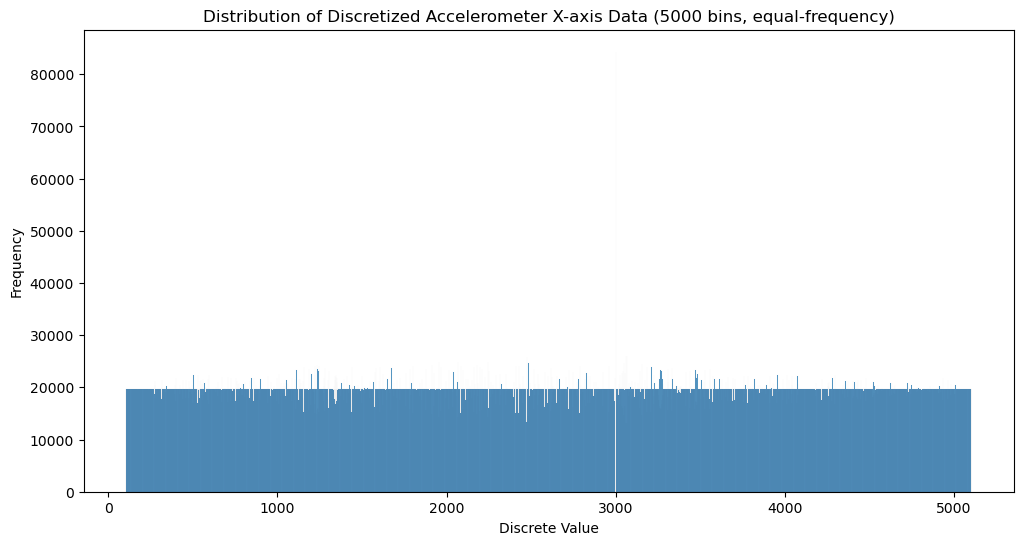

In [3]:
# ビンの数を設定
num_bins = 5000  # 必要に応じて調整

# ビンの境界を等頻度で設定
bins = np.percentile(acc_x, np.linspace(0, 100, num_bins + 1))

# データをビンに分割
discrete_data = np.digitize(acc_x, bins) - 1  # ビンのインデックスを取得し、0から始まるように調整

# 予約トークンを避けるためにシフト
discrete_data += 104

# 最大インデックスを確認
max_index = discrete_data.max()
print(f"Max index after shifting: {max_index}")

# vocab_sizeを確認（シフト後の最大値を考慮）
vocab_size = max_index + 1
print(f"Vocab size: {vocab_size}")

# 確認のための一部データ
print("Sample discrete data:", discrete_data[:10])
print("Discrete data range:", np.min(discrete_data), "to", np.max(discrete_data))

# 分布の視覚化
plt.figure(figsize=(12, 6))
sns.histplot(discrete_data.flatten(), bins=num_bins, kde=False)
plt.title(f"Distribution of Discretized Accelerometer X-axis Data ({num_bins} bins, equal-frequency)")
plt.xlabel("Discrete Value")
plt.ylabel("Frequency")
plt.show()

# 離散化されたデータを保存
np.save("train_token_ids_rebinned.npy", discrete_data)


In [4]:
discrete_data.min()

104

In [5]:
discrete_data.shape

(196072, 500)

In [6]:
#説明変数
X = discrete_data
#目的変数
Y = label

#おしり3万データを使う  
X_30000 = X[-40000:-10000,:]
label_30000 = label[-40000:-10000]
print(X_30000.shape)
print(label_30000.shape)

(30000, 500)
(30000,)


c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


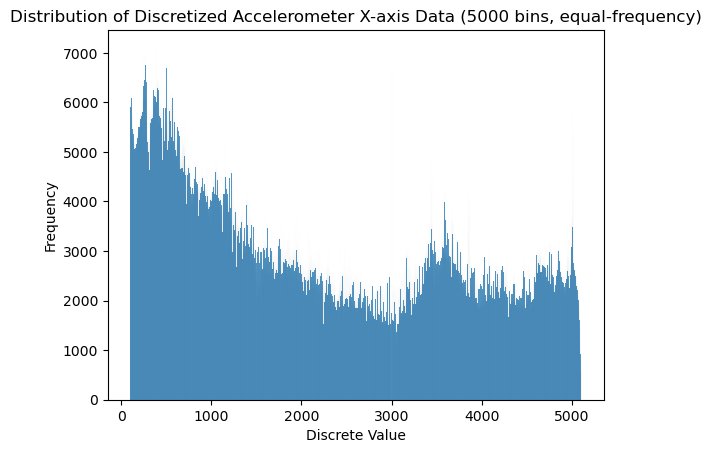

In [7]:
# X_30000のトークンの頻度を見てみる
sns.histplot(X_30000.flatten(), bins=num_bins, kde=False)
plt.title(f"Distribution of Discretized Accelerometer X-axis Data ({num_bins} bins, equal-frequency)")
plt.xlabel("Discrete Value")
plt.ylabel("Frequency")
plt.show()

## トレーニングデータの用意  
マスクされたトークン予測タスクでは、入力シーケンスの一部のトークンをランダムにマスクし、そのトークンを予測する

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class SensorDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.data[idx], dtype=torch.long)

        # CLSとSEPトークンを追加
        input_ids = torch.cat([torch.tensor([101]), input_ids, torch.tensor([102])]) # これで502シークエンス長になるはず

        attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

        # セグメントID（ここではすべて文1と仮定）
        token_type_ids = torch.zeros(input_ids.shape, dtype=torch.long)
        
        # ランダムにトークンをマスクする
        labels = input_ids.clone() # labelsにはもとのinput_ids502シーケンスが入っている
        mask_arr = (torch.rand(input_ids.shape) < 0.15) * (input_ids != 101) * (input_ids != 102)  # [CLS] と [SEP] をマスクしない
        input_ids[mask_arr] = 103  # 103は[MASK]トークンのIDに対応　複数のマスクもありうる

        return {
            "input_ids": input_ids, # マスク付きのもの　502シーケンス長で複数マスク可能性あり
            "attention_mask": attention_mask, # 
            "token_type_ids":token_type_ids,
            "labels": labels
        }



In [9]:
max_index

5104

In [10]:
vocab_size

5105

In [11]:

# トレーニングデータの読み込み（ビニングされたデータ）
#train_data = np.load("train_token_ids.npy")
train_data = X_30000

# データセットとデータローダの作成
train_dataset = SensorDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# BERTの設定を定義
config = BertConfig(
    vocab_size=vocab_size,  # ビンの数 + 104
    hidden_size=768,
    num_hidden_layers=6,
    num_attention_heads=12,
    intermediate_size=3072,
    max_position_embeddings=502,  # シーケンス長 + 1 (CLSトークン)
    type_vocab_size=2  # 通常、2つのトークンタイプ (タイプ0とタイプ1) を使用
)
from transformers import BertConfig, BertForMaskedLM
# モデルの準備
model = BertForMaskedLM(config)
#model.bert.embeddings = CustomBertEmbeddings(config)
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5105, 768, padding_idx=0)
      (position_embeddings): Embedding(502, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [12]:
# モデルの重みを確認
for param in model.parameters():
    if param.dtype != torch.float32:
        print(f"Parameter {param} has dtype {param.dtype}. Converting to float32.")
        param.data = param.data.float()


In [13]:
import os
import logging
import numpy as np
import json
from transformers import TrainerCallback, TrainingArguments, TrainerState, TrainerControl
from transformers import TrainingArguments, Trainer

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super().default(obj)

# ログディレクトリの作成
log_dir = './logs'
os.makedirs(log_dir, exist_ok=True)

# ログファイルの設定
logging.basicConfig(filename=os.path.join(log_dir, 'training.log'), level=logging.INFO)

# カスタムコールバックの定義
class CustomLoggingCallback(TrainerCallback):
    def on_log(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
        if state.log_history:
            log_entry = state.log_history[-1]
            log_entry_serialized = json.dumps(log_entry, cls=NumpyEncoder)
            logging.info(f"Epoch: {state.epoch}, Step: {state.global_step}, Log Entry: {log_entry_serialized}")

# トレーニング設定
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    save_steps=50,
    save_total_limit=2,
    prediction_loss_only=True,
    logging_steps=10,
    logging_dir=log_dir,  # ログを保存するディレクトリ
    logging_strategy="steps",  # ステップごとにログを保存
    save_strategy="steps",  # ステップごとにモデルを保存
)

# トレーナーの定義
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    callbacks=[CustomLoggingCallback],  # カスタムコールバックを追加
)

# トレーニングの実行
trainer.train()


  0%|          | 0/2814 [00:00<?, ?it/s]

c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 8.3051, 'grad_norm': 1.4733216762542725, 'learning_rate': 4.982231698649609e-05, 'epoch': 0.01}
{'loss': 7.4089, 'grad_norm': 1.4190919399261475, 'learning_rate': 4.964463397299218e-05, 'epoch': 0.02}
{'loss': 6.5321, 'grad_norm': 1.6197494268417358, 'learning_rate': 4.9466950959488276e-05, 'epoch': 0.03}
{'loss': 5.6533, 'grad_norm': 1.9894105195999146, 'learning_rate': 4.928926794598437e-05, 'epoch': 0.04}
{'loss': 4.9183, 'grad_norm': 2.2103991508483887, 'learning_rate': 4.911158493248046e-05, 'epoch': 0.05}


TypeError: Object of type int64 is not JSON serializable

In [ ]:
def validate_data_loader(data_loader, vocab_size):
    for batch in data_loader:
        input_ids = batch["input_ids"]
        labels = batch["labels"]

        if input_ids.max() >= vocab_size or labels.max() >= vocab_size:
            print(f"Error: Found out of range index in input_ids or labels. Max value should be less than {vocab_size}.")
            print(f"Max value in input_ids: {input_ids.max()}")
            print(f"Max value in labels: {labels.max()}")
            return False

        if input_ids.dtype != torch.long or labels.dtype != torch.long:
            print("Error: Data type mismatch. input_ids and labels should be of type torch.long.")
            print(f"input_ids dtype: {input_ids.dtype}")
            print(f"labels dtype: {labels.dtype}")
            return False

    print("Data validation passed.")
    return True

# データローダの検証
validate_data_loader(train_dataloader, vocab_size)


Data validation passed.


True

In [ ]:
# GPUメモリの解放
torch.cuda.empty_cache()

In [ ]:
del model
del train_dataset
del trainer

import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super().default(obj)

data = {"array": np.array([1, 2, 3])}

json_data = json.dumps(data, cls=NumpyEncoder)

print(json_data)

TypeError: Object of type ndarray is not JSON serializable